In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from xgboost import XGBRegressor

df= pd.read_csv("final_files/top_30_rain_shited.csv")

X = df.iloc[:, :-1]  # Features: all columns except the last one
y = df.iloc[:, -1] 

# Start timer
start_time = time.time()

# Train an XGBoost regressor
params = {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 250, 'subsample': 0.8}

model = XGBRegressor(**params)
model.fit(X, y)  # Train the model with entire dataset X and y

/home/fgrslab/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

/home/fgrslab/.local/lib/python3.10/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(
/home/fgrslab/.local/lib/python3.10/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(
/home/fgrslab/.local/lib/python3.10/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(
/home/fgrslab/.local/lib/python3.10/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(
/home/fgrslab/.local/lib/python3.10/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 

ValueError: x and y must have same first dimension, but have shapes (76,) and (100,)

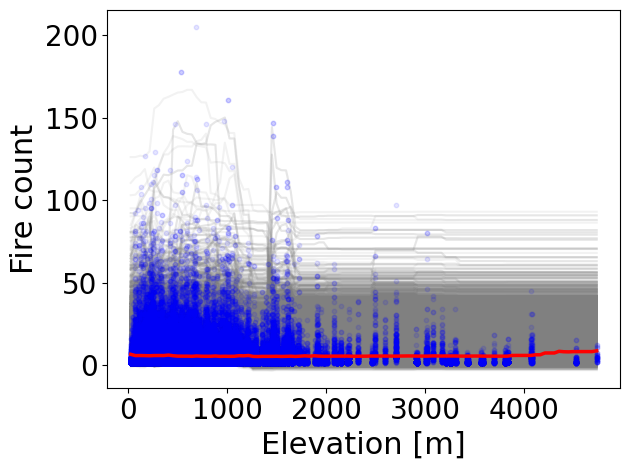

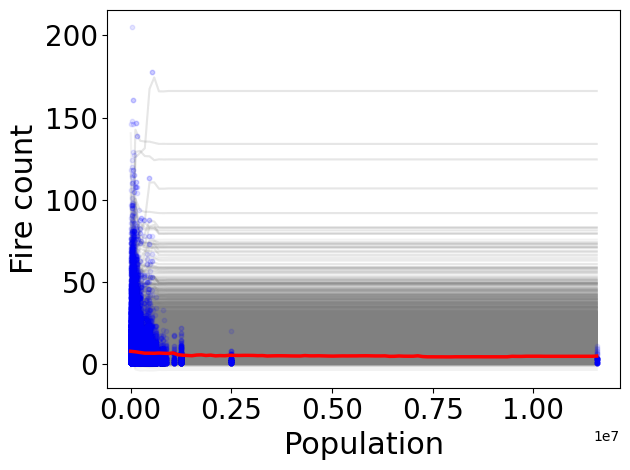

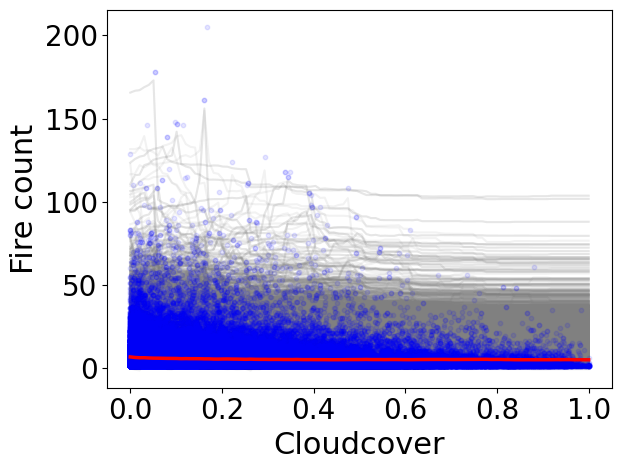

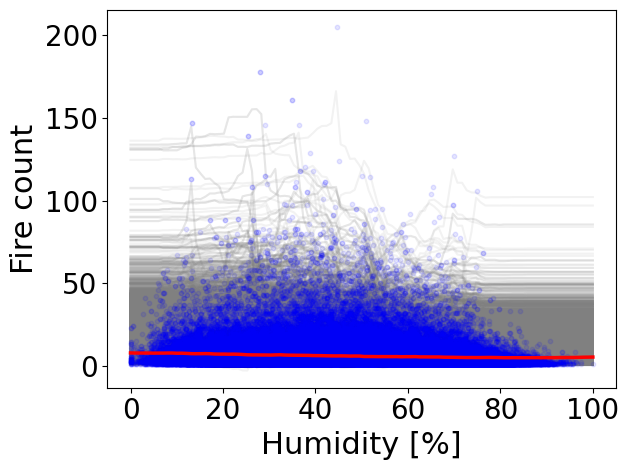

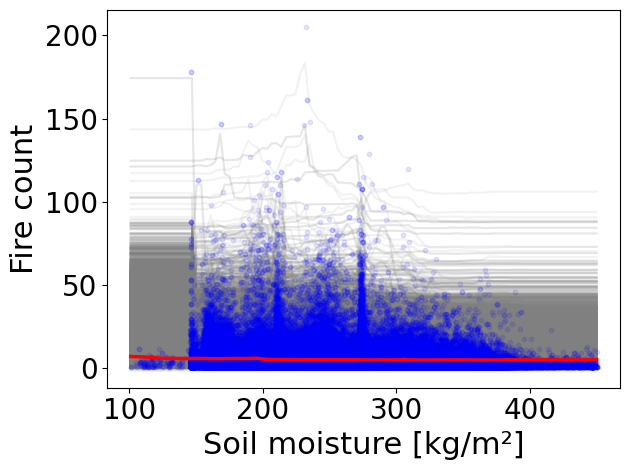

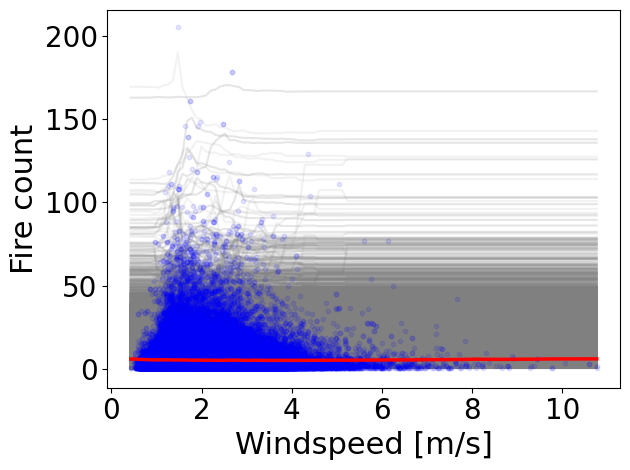

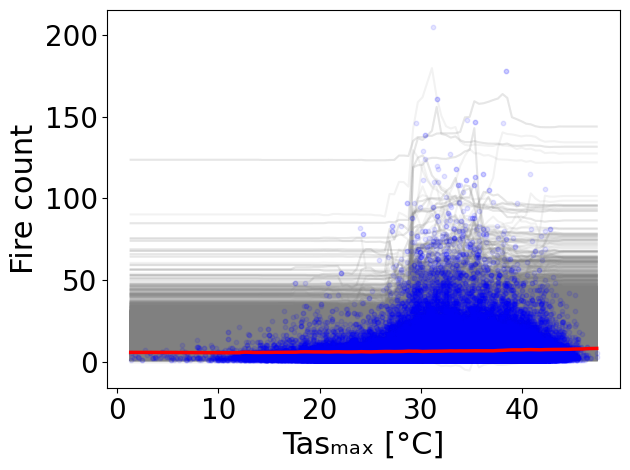

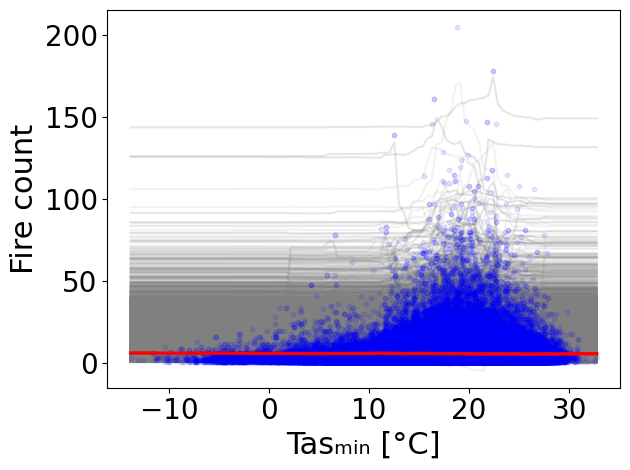

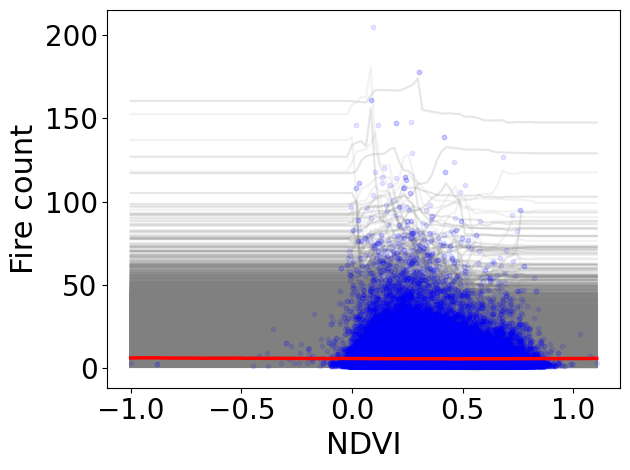

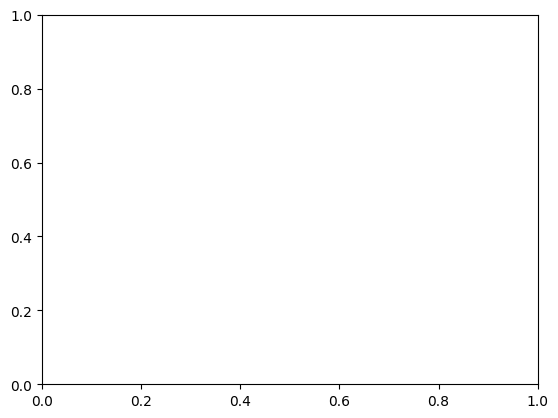

In [ ]:
# List of modified feature names for x-axis labels
modified_feature_names = ['Elevation [m]', 'Population', 'Cloudcover', 'Humidity [%]','Soil moisture [kg/m²]','Windspeed [m/s]','Tasₘₐₓ [°C]','Tasₘᵢₙ [°C]','NDVI','Forest cover fraction [%]','Prev year avg rain [mm]']  # Replace with your actual modified names

# Loop through each feature
for feature_name, modified_feature_name in zip(X.columns, modified_feature_names):
    feature_index = X.columns.get_loc(feature_name)

    # Compute ICE lines in parallel
    def compute_ice_line(model, X, feature_index, value_range):
        X_temp = X.copy()
        ice_lines = []
        for value in value_range:
            X_temp.iloc[:, feature_index] = value
            ice_lines.append(model.predict(X_temp))
        return np.array(ice_lines)

    value_range = np.linspace(X[feature_name].min(), X[feature_name].max(), 100)
    ice_lines = compute_ice_line(model, X, feature_index, value_range)

    # Compute PDP manually
    pdp_results = partial_dependence(model, X, [feature_index], grid_resolution=100)
    pdp_values = pdp_results['average'][0]
    pdp_grid = pdp_results['values'][0]

    # Ensure the grid of PDP matches the value range used for ICE
    if len(pdp_grid) != len(value_range):
        value_range = pdp_grid

    # Set up the plot
    fig, ax = plt.subplots()

    # Plot ICE lines with transparency
    for ice_line in ice_lines.T:
        ax.plot(value_range, ice_line, color='gray', alpha=0.1)

    # Plot actual data points over the ICE lines
    ax.scatter(X[feature_name], y, color='blue', s=10, alpha=0.1, label='Data points', zorder=10)

    # Plot PDP with increased visibility
    ax.plot(value_range, pdp_values, color='red', linewidth=2.5, label='PDP', zorder=11)

    # Labeling the plot
    ax.set_xlabel(modified_feature_name, fontsize=22)  # Set the modified feature name as xlabel
    ax.set_ylabel('Fire count', fontsize=22)  # Assuming 'Fire count' is the ylabel

    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=20)

    plt.tight_layout()
    
    # Save the plot as PNG and SVG
    plt.savefig(f'pdp_normal/{feature_name.lower()}.png', dpi=600)  # Save as PNG with 300 dpi resolution
    #plt.savefig(f'pdp_normal/{feature_name.lower()}.svg')  # Save as SVG

    # Show plot
    #plt.show()

# End timer and print elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


/home/fgrslab/.local/lib/python3.10/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


pdp_grid shape: (76,), first 5 values: [1. 2. 3. 4. 5.]
pdp_values shape: (76,), first 5 values: [5.7399893 5.724481  5.638599  5.3192987 5.2555037]
ice_lines shape: (76, 161123)
Execution time: 7321.231022834778 seconds


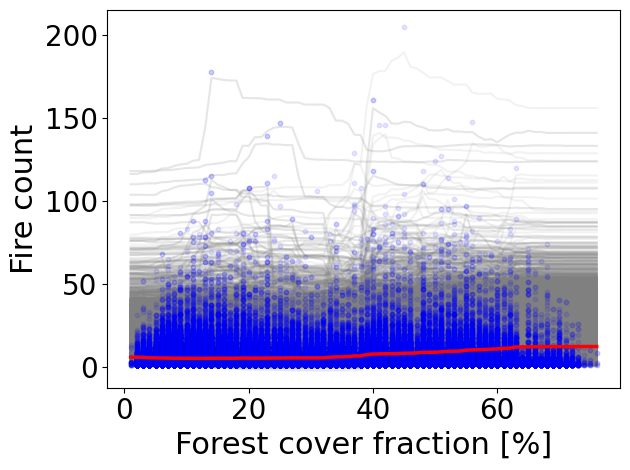

In [ ]:
# Define the feature for which we want to plot PDP and ICE by name
feature_name = 'forestcoverfraction'  # Replace with the actual column name you want to plot
feature_index = X.columns.get_loc(feature_name)

# Compute PDP manually
pdp_results = partial_dependence(model, X, [feature_index], grid_resolution=100)
pdp_values = pdp_results['average'][0]
pdp_grid = pdp_results['values'][0]

# Debugging: print shapes and some values
print(f"pdp_grid shape: {pdp_grid.shape}, first 5 values: {pdp_grid[:5]}")
print(f"pdp_values shape: {pdp_values.shape}, first 5 values: {pdp_values[:5]}")

# Compute ICE lines using pdp_grid
def compute_ice_line(model, X, feature_index, value_range):
    X_temp = X.copy()
    ice_lines = []
    for value in value_range:
        X_temp.iloc[:, feature_index] = value
        ice_lines.append(model.predict(X_temp))
    return np.array(ice_lines)

ice_lines = compute_ice_line(model, X, feature_index, pdp_grid)

# Debugging: print shapes of ICE lines
print(f"ice_lines shape: {ice_lines.shape}")

# Set up the plot
fig, ax = plt.subplots()

# Plot ICE lines with transparency
for ice_line in ice_lines.T:
    ax.plot(pdp_grid, ice_line, color='gray', alpha=0.1)

# Plot actual data points over the ICE lines
ax.scatter(X[feature_name], y, color='blue', s=10, alpha=0.1, label='Data points', zorder=10)

# Plot PDP with increased visibility
ax.plot(pdp_grid, pdp_values, color='red', linewidth=2.5, label='PDP', zorder=11)

ax.set_xlabel('Forest cover fraction [%]', fontsize=22)
ax.set_ylabel('Fire count', fontsize=22)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
# Save the plot as PNG and SVG
plt.savefig(f'/pdp_final_11/pdp_normal/{feature_name.lower()}.png', dpi=600)
#plt.savefig(f'pdp_normal/{feature_name.lower()}.svg')  # Save as SVG

# Show plot
#plt.show()

# End timer
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")


/home/fgrslab/.local/lib/python3.10/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


Elapsed time: 7677.62 seconds


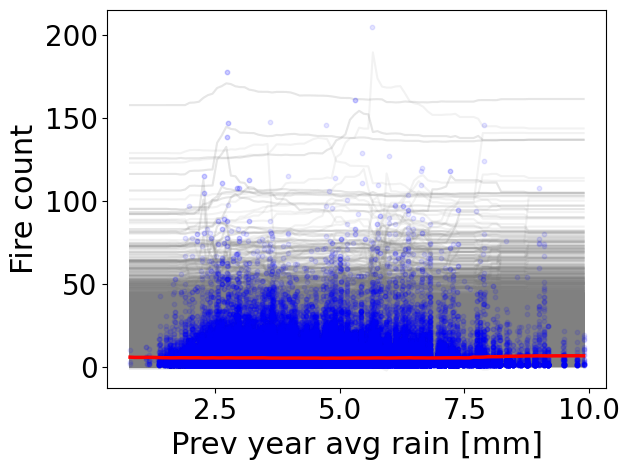

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
import time


# Set the single feature you want to analyze
feature_name = 'rain_shifted'  # Replace with your actual feature name
modified_feature_name = 'Prev year avg rain [mm]'  # Replace with your actual modified feature name

# Get the index of the feature
feature_index = X.columns.get_loc(feature_name)

# Function to compute ICE lines
def compute_ice_line(model, X, feature_index, value_range):
    X_temp = X.copy()
    ice_lines = []
    for value in value_range:
        X_temp.iloc[:, feature_index] = value
        ice_lines.append(model.predict(X_temp))
    return np.array(ice_lines)

# Define the value range
value_range = np.linspace(X[feature_name].min(), X[feature_name].max(), 100)
ice_lines = compute_ice_line(model, X, feature_index, value_range)

# Compute PDP manually
pdp_results = partial_dependence(model, X, [feature_index], grid_resolution=100)
pdp_values = pdp_results['average'][0]
pdp_grid = pdp_results['values'][0]

# Ensure the grid of PDP matches the value range used for ICE
if len(pdp_grid) != len(value_range):
    value_range = pdp_grid

# Set up the plot
fig, ax = plt.subplots()

# Plot ICE lines with transparency
for ice_line in ice_lines.T:
    ax.plot(value_range, ice_line, color='gray', alpha=0.1)

# Plot actual data points over the ICE lines
ax.scatter(X[feature_name], y, color='blue', s=10, alpha=0.1, label='Data points', zorder=10)

# Plot PDP with increased visibility
ax.plot(value_range, pdp_values, color='red', linewidth=2.5, label='PDP', zorder=11)

# Labeling the plot
ax.set_xlabel(modified_feature_name, fontsize=22)  # Set the modified feature name as xlabel
ax.set_ylabel('Fire count', fontsize=22)  # Assuming 'Fire count' is the ylabel

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()

# Save the plot as PNG and SVG
plt.savefig(f'pdp_normal/{feature_name.lower()}.png', dpi=600)
# plt.savefig(f'pdp_normal/{feature_name.lower()}.svg')  # Save as SVG

# Show plot
# plt.show()

# End timer and print elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


/home/fgrslab/.local/lib/python3.10/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


Elapsed time: 8020.10 seconds


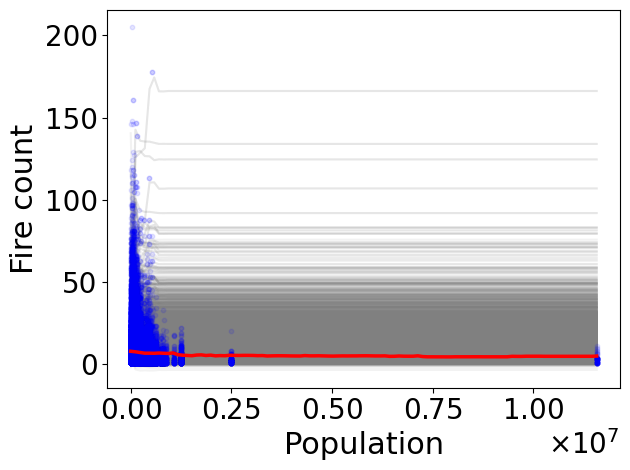

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
import time
from matplotlib.ticker import ScalarFormatter
# Assuming 'X' is your feature matrix and 'y' is your target variable
# Assuming 'model' is your trained model
# Assuming 'feature_name' is the name of the feature you're interested in
# Assuming 'modified_feature_name' is the modified name for that feature

# Set the single feature you want to analyze
feature_name = 'population'  # Replace with your actual feature name
modified_feature_name = 'Population'  # Replace with your actual modified feature name

# Get the index of the feature
feature_index = X.columns.get_loc(feature_name)

# Function to compute ICE lines
def compute_ice_line(model, X, feature_index, value_range):
    X_temp = X.copy()
    ice_lines = []
    for value in value_range:
        X_temp.iloc[:, feature_index] = value
        ice_lines.append(model.predict(X_temp))
    return np.array(ice_lines)

# Define the value range
value_range = np.linspace(X[feature_name].min(), X[feature_name].max(), 100)
ice_lines = compute_ice_line(model, X, feature_index, value_range)

# Compute PDP manually
pdp_results = partial_dependence(model, X, [feature_index], grid_resolution=100)
pdp_values = pdp_results['average'][0]
pdp_grid = pdp_results['values'][0]

# Ensure the grid of PDP matches the value range used for ICE
if len(pdp_grid) != len(value_range):
    value_range = pdp_grid

# Set up the plot
fig, ax = plt.subplots()

# Plot ICE lines with transparency
for ice_line in ice_lines.T:
    ax.plot(value_range, ice_line, color='gray', alpha=0.1)

# Plot actual data points over the ICE lines
ax.scatter(X[feature_name], y, color='blue', s=10, alpha=0.1, label='Data points', zorder=10)

# Plot PDP with increased visibility
ax.plot(value_range, pdp_values, color='red', linewidth=2.5, label='PDP', zorder=11)

# Labeling the plot
ax.set_xlabel(modified_feature_name, fontsize=22)  # Set the modified feature name as xlabel
ax.set_ylabel('Fire count', fontsize=22)  # Assuming 'Fire count' is the ylabel

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=20)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# Increase font size of the scientific notation
ax.xaxis.get_offset_text().set_fontsize(20)
plt.tight_layout()

# Save the plot as PNG and SVG
plt.savefig(f'pdp_normal/{feature_name.lower()}.png', dpi=600)
# plt.savefig(f'pdp_normal/{feature_name.lower()}.svg')  # Save as SVG

# Show plot
# plt.show()

# End timer and print elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
